In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import cv2

Using TensorFlow backend.


In [2]:
image_size = (96, 96, 3)

datagen = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,  fill_mode="nearest",
    rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.05,
)

In [3]:
training_set = datagen.flow_from_directory(
    '../age_dataset/', target_size = image_size[:2],  batch_size = 32, class_mode = 'categorical', subset='training', 
    color_mode='rgb'
)

Found 18912 images belonging to 3 classes.


In [4]:
validation_set = datagen.flow_from_directory(
    '../age_dataset/',  target_size = image_size[:2], batch_size = 32, class_mode = 'categorical', subset='validation', 
    color_mode='rgb'
)

Found 994 images belonging to 3 classes.


In [5]:
training_set.class_indices

{'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
filepath = "age_model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2)

opt = Adam(lr=0.001, decay=0.000001)

In [7]:
def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape=image_size, activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (3, 3)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    classifier.add(BatchNormalization(axis=-1))
    
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Flatten())
#     classifier.add(Dense(1024, activation='relu'))
    classifier.add(BatchNormalization())
#     classifier.add(Dropout(0.5))
    classifier.add(Dense(units = 3, activation = 'sigmoid'))
    classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['acc'])
    return classifier

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

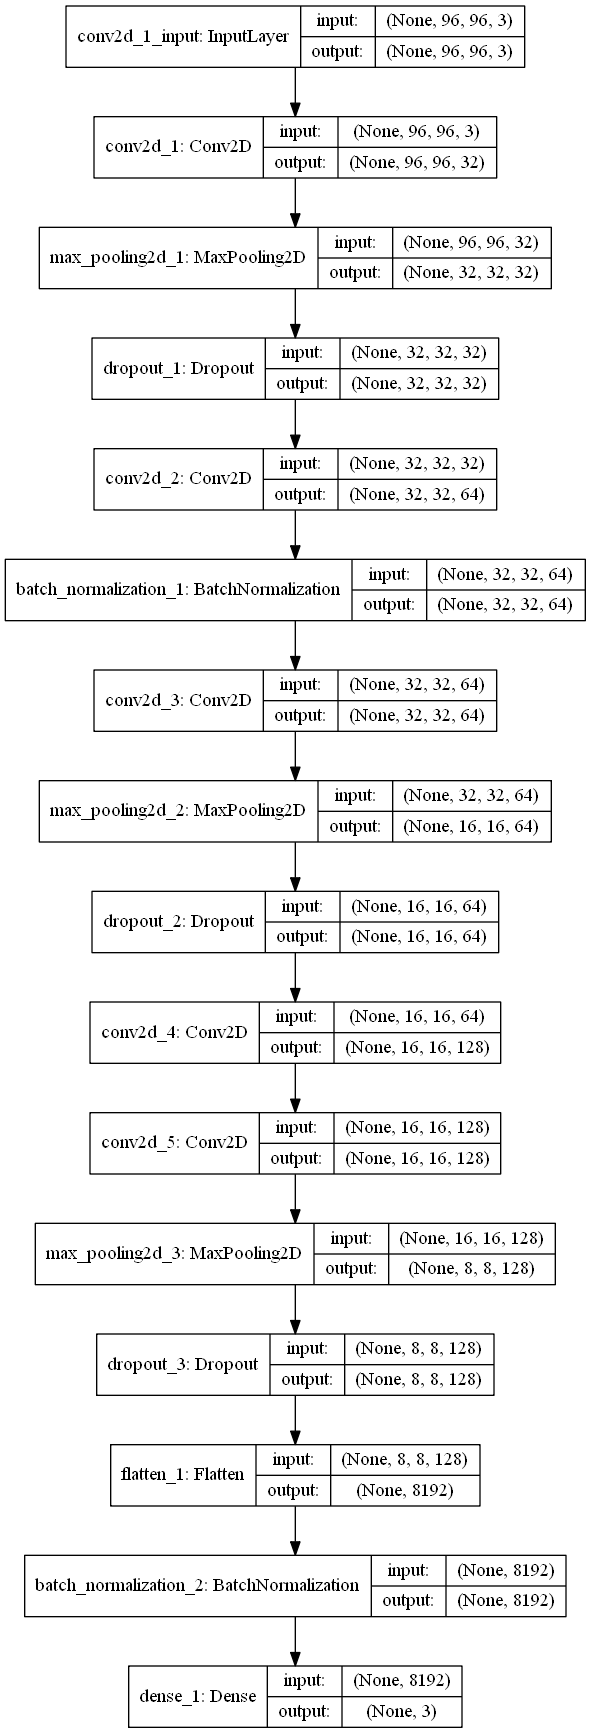

In [8]:
neuralnetwork = cnn(image_size)

neuralnetwork.summary()

plot_model(neuralnetwork, to_file='age_model.png', show_shapes=True, show_layer_names=True)

In [9]:
history = neuralnetwork.fit_generator(
    training_set,
    validation_data = validation_set,
    callbacks=[es, ckpt, rlp], epochs = 1000, 
    class_weight={0:1, 1:4.5092, 2:1.6111}
)

Epoch 1/1000
591/591 [==============================] - 835s 1s/step - loss: 1.6985 - acc: 0.3959 - val_loss: 0.7002 - val_acc: 0.2173

Epoch 00001: loss improved from inf to 1.69852, saving model to age_model.h5
Epoch 2/1000
591/591 [==============================] - 393s 665ms/step - loss: 1.6882 - acc: 0.4032 - val_loss: 0.9029 - val_acc: 0.3370

Epoch 00002: loss improved from 1.69852 to 1.68824, saving model to age_model.h5
Epoch 3/1000
591/591 [==============================] - 396s 671ms/step - loss: 1.6877 - acc: 0.3938 - val_loss: 1.0985 - val_acc: 0.3893

Epoch 00003: loss improved from 1.68824 to 1.68767, saving model to age_model.h5
Epoch 4/1000
591/591 [==============================] - 400s 677ms/step - loss: 1.6953 - acc: 0.4123 - val_loss: 0.8664 - val_acc: 0.4296

Epoch 00004: loss did not improve from 1.68767
Epoch 5/1000
591/591 [==============================] - 398s 673ms/step - loss: 1.6820 - acc: 0.3985 - val_loss: 1.0936 - val_acc: 0.4366

Epoch 00005: loss impr

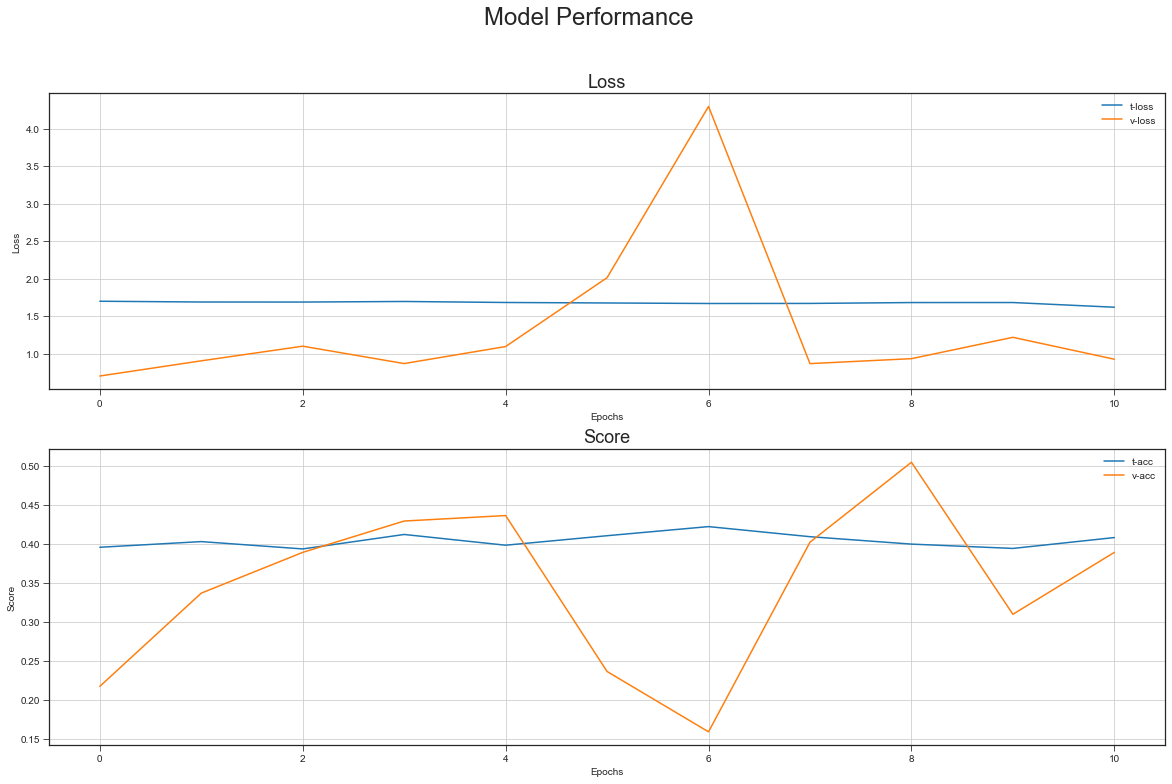

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['acc'], label='t-acc')
ax[1].plot(history.history['val_acc'], label='v-acc')
ax[1].set_title('Score', fontsize=18)
ax[1].set_ylabel('Score')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')